In [1]:
import sys
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
import sys
from pathlib import Path
sys.path.append(Path('../deterministic'))
from deterministic.mps import MPS
import src.constants as constants
from display_data.data_acquisition_shadow import derandomized_classical_shadow, randomized_classical_shadow
from display_data.prediction_shadow import estimate_exp
sys.path.append(Path('../src'))
from src.tfim_hamiltonian_open_fermion import TfimHamiltonianOpenFermion
from src.mps_quantum_state import MPSQuantumState
import matplotlib.pyplot as plt

In [2]:
qubit_num = 10
psi = pt.rand(2**qubit_num, dtype=pt.cdouble)
mps = MPS.from_state_vector(qubit_num, psi)
print(mps)

MPS None:
	visible_num = 10
	phys_dims = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
	bond_dims = [2, 4, 8, 16, 32, 16, 8, 4, 2]
	ext_bond_dims = [1, 2, 4, 8, 16, 32, 16, 8, 4, 2, 1]
	orth_idx = None



In [2]:
#generate a random tensor list
qubit_num = 12
bond_dim = 50
tensor_liste = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))

In [2]:
# this function converts the stored measurement outcomes to the correct shape needed for the shadow prediction
def conversion_to_prediction_shadow_dict_shape(measurement_procedure, measurement_index, qubit_num):
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(qubit_num))
    strs = to_str_func(measurement_index)
    dirac_rep = np.zeros(list(measurement_index.shape) + [qubit_num], dtype=np.int8)
    for bit_ix in range(0, qubit_num):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        dirac_rep[...,bit_ix] = fetch_bit_func(strs).astype("int8")
    measurement_array = np.where(dirac_rep == 1, -1, dirac_rep)
    measurement_array = np.where(dirac_rep == 0, 1, measurement_array)
    measurement = np.dstack((measurement_procedure, np.array(measurement_array, dtype=int)))
    return measurement

In [3]:
ratio_h_j = 0.1
qubit_num = 12
save_direc_groundstate = Path('data/Diagonal_hamiltonian/groundstate_dict.npy')
ground_state_dict = np.load(save_direc_groundstate, allow_pickle='TRUE')
ground_state_dict = ground_state_dict.item()
ground_state = ground_state_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)]
mps = MPS.from_state_vector(qubit_num, ground_state)
tensor_liste = mps.tensors

In [4]:
save_direc_eigs = Path('data/Diagonal_hamiltonian/eigenvalues_first_three_dict.npy')
energy_dict = np.load(save_direc_eigs, allow_pickle=True)
energy_dict = energy_dict.item()
energy_brute = energy_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)][0]
print(energy_brute)

-11.035025070620321


In [8]:
print(MPSQuantumState(qubit_num, tensor_liste).measure(10))
#print(MPSQuantumState(qubit_num, tensor_liste).measurement_shadow(4, 10))

(tensor([[1., 1., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 1., 1., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 1., 1., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 1., 1., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 1., 1., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 1., 1., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 1., 1., 0., 0., 0., 1., 0., 0.]]), tensor([[0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975,
         0.9975],
        [0.9994, 0.9994, 0.9994, 0.9994, 0.9994, 0.9994, 0.9994, 0.9994, 0.9994,
         0.9994],
        [0.9994, 0.9994, 0.9994, 0.9994, 0.9994, 0.9994, 0.9994, 0.9994, 0.9994,
         0.9994],
        [0.9994, 0.9994, 0.9994, 0.9994, 0.9994, 0.9994, 0.9994, 0.9994, 0.9994,
         0.9994],
 

In [17]:
# now we have a method to keep only the unique indices, now we convert the measurements to the necessary shape for shadow prediction
batches = 12
num_of_measurements = np.array([10, 20, 50, 100, 200, 500, 1000])
num_of_measurements_per_rot = 30
energies_different_meas_num = np.zeros((np.size(num_of_measurements), batches))
for b in range(batches):
    for i in range(np.size(num_of_measurements)):
        meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, tensor_liste).measurement_shadow(num_of_measurements[i], num_of_measurements_per_rot)
        energies = np.zeros(len(meas_outcomes))
        for n in range(len(meas_outcomes)):
            # first get the unique elements of this torch tensor
            unique_meas_outcomes, index_perm = np.unique(meas_outcomes[n].numpy(), return_index=True)
            # probs_sorted = probs[n][index_perm] # if we just want to compute the energy we can easily use these probabilities we get for free when sampling
            # when we want to determine the gradient via autodiff though, the connection to the underlying tensors has to be more direct
            # thus we compute the probabilities again, from the tensors directly
            probs_direct = MPSQuantumState(qubit_num, tensor_liste).rotate_pauli(meas_procedure[n]).prob(pt.tensor(unique_meas_outcomes))
            measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(unique_meas_outcomes), unique_meas_outcomes, qubit_num)
            energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_direct) #run this for both probs
        energy = np.mean(energies)
        energies_different_meas_num[i,b] = energy

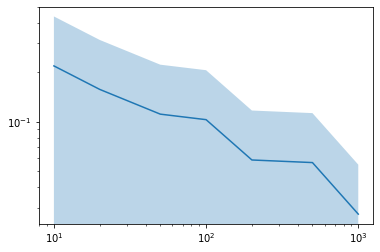

In [18]:
rel_error = np.abs((energies_different_meas_num - energy_brute) / energy_brute)
rel_error_mean = np.mean(rel_error, axis=1)
rel_error_std = np.mean(rel_error, axis=1)
plt.plot(num_of_measurements, rel_error_mean)
plt.fill_between(num_of_measurements, rel_error_mean - rel_error_std, rel_error_mean + rel_error_std, alpha=0.3)
plt.yscale('log')
plt.xscale('log')

In [19]:
# now we have a method to keep only the unique indices, now we convert the measurements to the necessary shape for shadow prediction
batches = 12
num_of_measurements = np.array([10, 20, 50, 100, 200, 500, 1000])
num_of_measurements_per_rot = 30
energies_different_meas_num = np.zeros((np.size(num_of_measurements), batches))
for b in range(batches):
    for i in range(np.size(num_of_measurements)):
        meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, tensor_liste).measurement_shadow(num_of_measurements[i], num_of_measurements_per_rot)
        energies = np.zeros(len(meas_outcomes))
        for n in range(len(meas_outcomes)):
            # first get the unique elements of this torch tensor
            unique_meas_outcomes, index_perm = np.unique(meas_outcomes[n].numpy(), return_index=True)
            probs_sorted = probs[n][index_perm] # if we just want to compute the energy we can easily use these probabilities we get for free when sampling
            # when we want to determine the gradient via autodiff though, the connection to the underlying tensors has to be more direct
            # thus we compute the probabilities again, from the tensors directly
            #probs_direct = MPSQuantumState(qubit_num, tensor_liste).rotate_pauli(meas_procedure[n]).prob(pt.tensor(unique_meas_outcomes))
            measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(unique_meas_outcomes), unique_meas_outcomes, qubit_num)
            energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_sorted) #run this for both probs
        energy = np.mean(energies)
        energies_different_meas_num[i,b] = energy

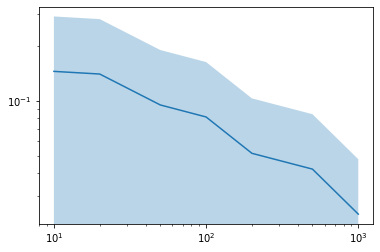

In [20]:
rel_error = np.abs((energies_different_meas_num - energy_brute) / energy_brute)
rel_error_mean = np.mean(rel_error, axis=1)
rel_error_std = np.mean(rel_error, axis=1)
plt.plot(num_of_measurements, rel_error_mean)
plt.fill_between(num_of_measurements, rel_error_mean - rel_error_std, rel_error_mean + rel_error_std, alpha=0.3)
plt.yscale('log')
plt.xscale('log')

In [ ]:
# now we try to estimate the gradient directly by contracting the mps with hamiltonian
#generate a random tensor list
qubit_num = 12
bond_dim = 50
tensor_liste = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))